In this kernel I analyze and plot the *LandAverageTemperature* and the *LandAverageTemperatureUncertainty* features of the *GlobalTemperatures* file.

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", color_codes=True)

from scipy import stats

In [2]:
data_dir = './'

In [3]:
global_t = pd.read_csv(data_dir + 'GlobalTemperatures.csv')
global_t.index = pd.to_datetime(global_t['dt'],infer_datetime_format=True)
del global_t['dt']
global_t.tail()

LandAverageTemperature  LandAverageTemperatureUncertainty  \
dt                                                                      
2015-08-01                  14.755                              0.072   
2015-09-01                  12.999                              0.079   
2015-10-01                  10.801                              0.102   
2015-11-01                   7.433                              0.119   
2015-12-01                   5.518                              0.100   

            LandMaxTemperature  LandMaxTemperatureUncertainty  \
dt                                                              
2015-08-01              20.699                          0.110   
2015-09-01              18.845                          0.088   
2015-10-01              16.450                          0.059   
2015-11-01              12.892                          0.093   
2015-12-01              10.725                          0.154   

            LandMinTemperature  LandMinTemperatureUncertainty  \
dt                                                              
2015-08-01               9.005                          0.170   
2015-09-01               7.199                          0.229   
2015-10-01               5.232                          0.115   
2015-11-01               2.157                          0.106   
2015-12-01               0.287                          0.099   

            LandAndOceanAverageTemperature  \
dt                                           
2015-08-01                          17.589   
2015-09-01                          17.049   
2015-10-01                          16.290   
2015-11-01                          15.252   
2015-12-01                          14.774   

            LandAndOceanAverageTemperatureUncertainty  
dt                                                     
2015-08-01                                      0.057  
2015-09-01                                      0.058  
2015-10-01                                      0.062  
2015-11-01                                      0.063  
2015-12-01                                      0.062

## LandAverageTemperature

In [4]:
global_by_year = global_t.groupby(global_t.index.year)
avg_by_year = global_by_year.mean()['LandAverageTemperature']

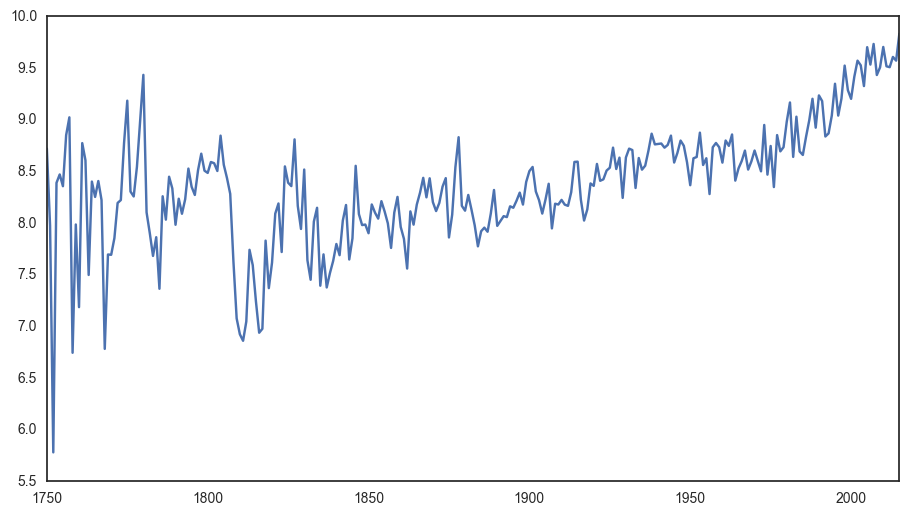

In [5]:
f, ax = plt.subplots(figsize=(11, 6))
_ = avg_by_year.plot(ax=ax)

Approximately before year 1850, there seems to be a lot of rumor.

## LandAverageTemperatureUncertainty

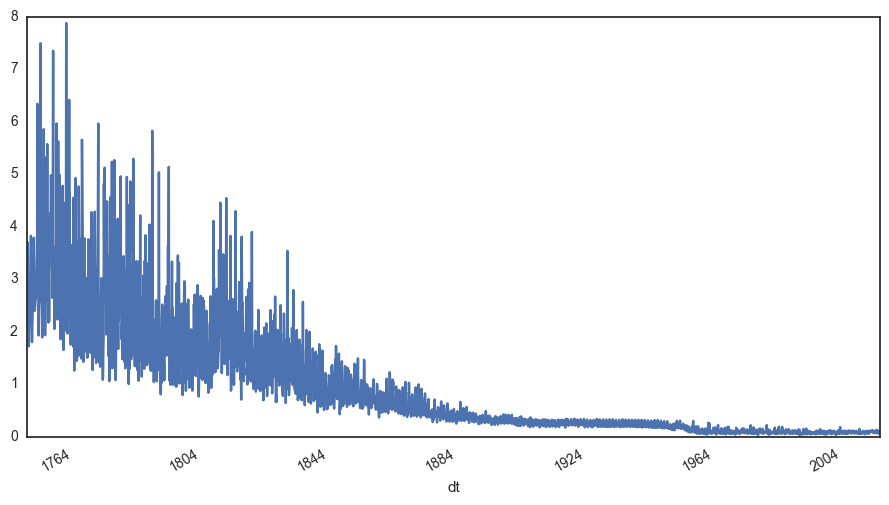

In [6]:
f, ax = plt.subplots(figsize=(11, 6))
temp_uncertainty = global_t['LandAverageTemperatureUncertainty'].dropna()
_ = temp_uncertainty.plot(ax=ax)

In [7]:
from scipy.stats import skew
skewness = skew(temp_uncertainty)
print('Skewness of "LandAverageTemperatureUncertainty" is {}'.format(skewness))

Skewness of "LandAverageTemperatureUncertainty" is 1.7797565065630188


I want to consider only lower levels of uncertainty. I will consider here values smaller than the median. Please leave a comment if you want to explain the best solution for this problem. I compute first the average by year because I use this info below to index average temperatures.

In [8]:
avg_uncertainty_by_year = global_t.groupby(global_t.index.year).mean()['LandAverageTemperatureUncertainty']
avg_uncertainty_smaller_than_median = avg_uncertainty_by_year[
    avg_uncertainty_by_year < avg_uncertainty_by_year.median()]
print('The median value of "LandAverageTemperatureUncertainty" means by year is {:.4f}' \
      .format(avg_uncertainty_by_year.median()))

The median value of "LandAverageTemperatureUncertainty" means by year is 0.4056


## Temperature differences between years

I plot here the difference between the average temperature of each year and the previous one.

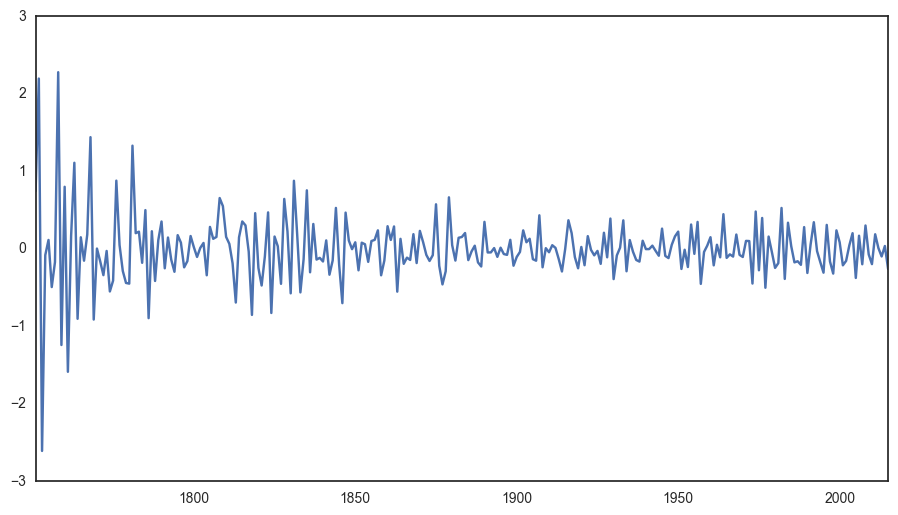

In [9]:
prev_year_inc = (avg_by_year.shift(1) - avg_by_year).dropna()

f, ax = plt.subplots(figsize=(11, 6))
_ = prev_year_inc.plot(ax=ax)

This is the same plot without the less reliable data.

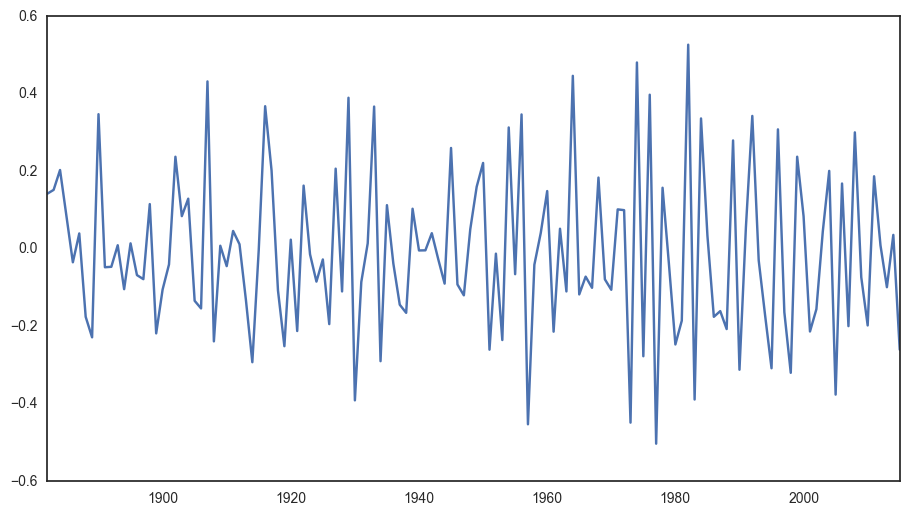

In [10]:
f, ax = plt.subplots(figsize=(11, 6))
_ = prev_year_inc.ix[avg_uncertainty_smaller_than_median.index].plot(ax=ax)


## LandAverageTemperature with less uncertainty

I plot here the average temperatures by year discarding the less reliable data. I also highlight local maxima. I compute these maximum values in two steps: first, I compute the local maxima from the values, and then again I compute the local maxima of the local maxima. Please leave a comment if you know a better way to do this.

In [11]:
reliable_avg_temps = avg_by_year[avg_uncertainty_smaller_than_median.index]

In [5]:
import numpy as np
from scipy.signal import argrelextrema

In [13]:
maxima_idx = argrelextrema(reliable_avg_temps.as_matrix(), np.greater)
maxima = reliable_avg_temps.iloc[maxima_idx[0]]

# one more time: compute the local maxima of the local maxima
maxima2_idx = argrelextrema(maxima.as_matrix(), np.greater)
# the numeric indexes in "maxima2_idx" refer to the "maxima" series.
maxima2  = reliable_avg_temps.ix[maxima.index[maxima2_idx]]
print('Maxima maxima:')
print(maxima2)

Maxima maxima:
1889    8.319000
1901    8.541917
1915    8.593167
1926    8.728833
1931    8.719250
1938    8.863667
1944    8.845000
1953    8.873750
1963    8.856000
1973    8.948250
1981    9.165833
2007    9.732167
Name: LandAverageTemperature, dtype: float64


I draw the local maxima in red, the local maxima of the local maxima in black.

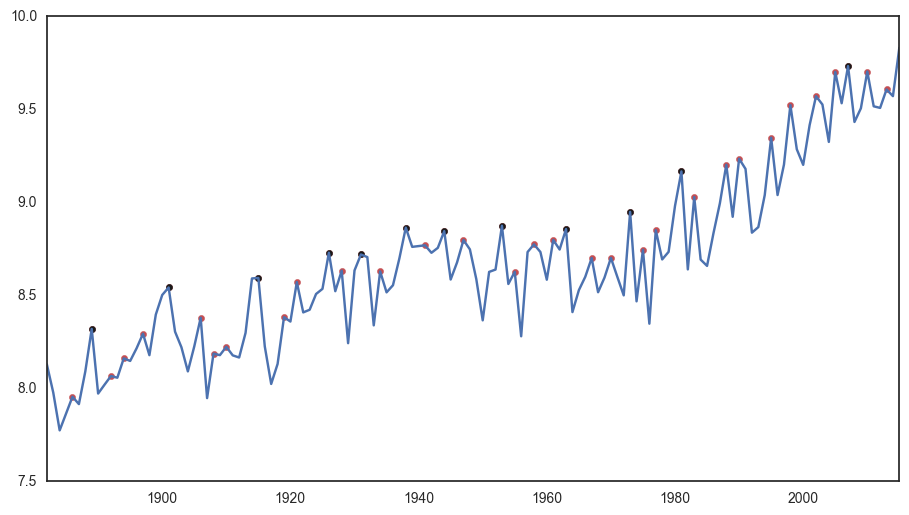

In [14]:
f, ax = plt.subplots(figsize=(11, 6))
reliable_avg_temps.plot(ax=ax)
plt.scatter(maxima.index, maxima.as_matrix(), color='r')
plt.scatter(maxima2.index, maxima2.as_matrix(), color='k')
pass

## Distribution analysis

I execute a T-test between averages of the first and second halves of the XX century. According to the test result, the difference between the two periods is not due to chance.

In [15]:
import scipy
first_half_XX = reliable_avg_temps.ix[1901:1950]
second_half_XX = reliable_avg_temps.ix[1951:2000]
ttest = scipy.stats.ttest_ind(first_half_XX, second_half_XX)
print('T-test p-value = {:.20f}'.format(ttest[1]))

T-test p-value = 0.00000000327834162280


## Test maxima

In [15]:
a = np.array([2, 1, 2, 3, 2, 0, 1, 0])
np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]


array([False,  True, False, False, False,  True, False,  True], dtype=bool)

In [6]:
max_idx = argrelextrema(a, np.greater)

In [7]:
max_idx

(array([3, 6]),)

In [8]:
a[1:]

array([1, 2, 3, 2, 0, 1, 0])

In [9]:
a[:-1]

array([2, 1, 2, 3, 2, 0, 1])

In [10]:
a[1:] < a[:-1]

array([ True, False, False,  True,  True, False,  True], dtype=bool)

In [13]:
a[:-1] < a[1:]

array([False,  True,  True, False, False,  True, False], dtype=bool)